In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Предобработка данных

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)

mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
pe = pd.read_excel('factors/russia/PE.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)

imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

for df in (prices, mcap, pe, volume, imoex):
    df.replace(0, np.nan, inplace=True)

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 10_000_000)

factorizer = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Mean(3),
    pqr.Hold(3),
)

size = factorizer(mcap, better="less")
value = factorizer(pe, better="less")

benchmark = pqr.Benchmark.from_index(imoex["IMOEX"], name="IMOEX")

Сначала строим однофакторные портфели по топ 20%

In [5]:
builder = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    pqr.TheoreticalAllocation(),
)

q02 = pqr.fm.Quantiles(0, 0.2)

In [6]:
size_portfolio = builder(
    universe, 
    longs=q02(size),
    name="Size"
)

value_portfolio = builder(
    universe, 
    longs=q02(value),
    name="Value"
)

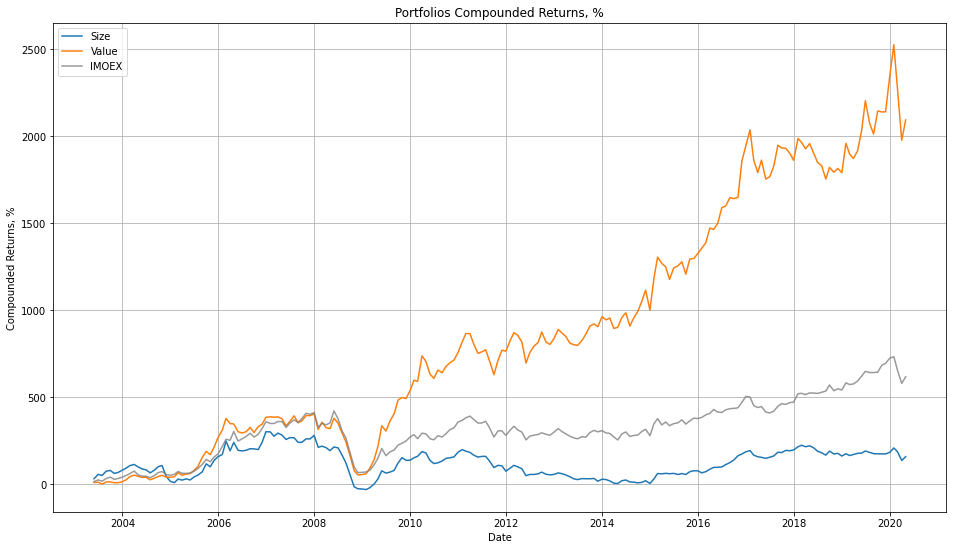

,Size,Value
"Total Return, %",157.32,2093.94
"CAGR, %",5.72,19.92
"Mean Return, %",12.32* (1.40),22.47*** (3.17)
"Volatility, %",36.32,29.21
"Win Rate, %",52.45,58.33
"Mean Turnover, %",235.33,223.41
"Maximum Drawdown, %",-83.08,-69.79
"Value at Risk, %",-52.80,-33.39
"Expected Tail Loss, %",-77.82,-53.15
"Expected Tail Reward, %",91.36,77.59


In [7]:
summary = pqr.dash.SummaryDashboard(benchmark)
summary([size_portfolio, value_portfolio])

# Weighted Multifactor

Все просто - сводим мульифакторный выбор к 1-факторному

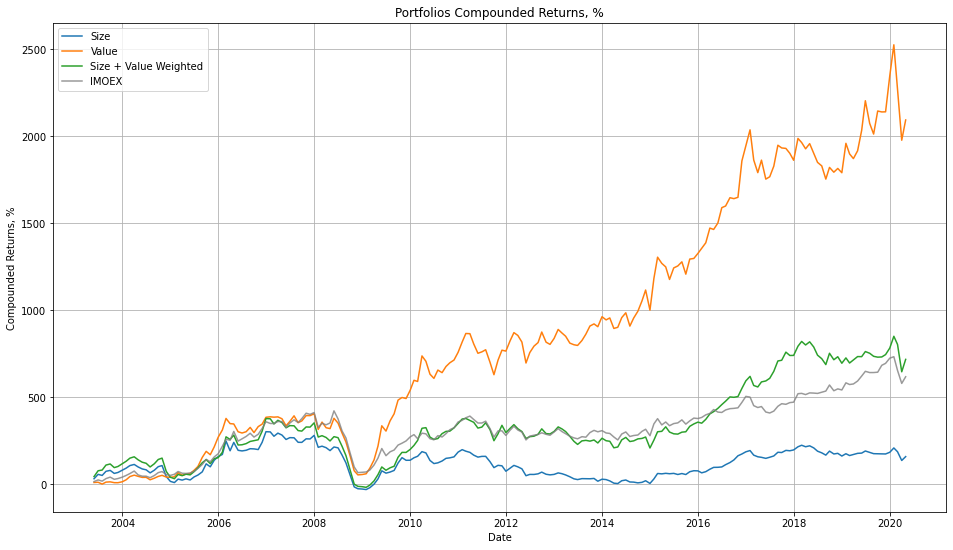

,Size,Value,Size + Value Weighted
"Total Return, %",157.32,2093.94,716.67
"CAGR, %",5.72,19.92,13.15
"Mean Return, %",12.32* (1.40),22.47*** (3.17),18.57** (2.21)
"Volatility, %",36.32,29.21,34.66
"Win Rate, %",52.45,58.33,60.29
"Mean Turnover, %",235.33,223.41,219.51
"Maximum Drawdown, %",-83.08,-69.79,-83.06
"Value at Risk, %",-52.80,-33.39,-47.20
"Expected Tail Loss, %",-77.82,-53.15,-75.59
"Expected Tail Reward, %",91.36,77.59,88.43


In [8]:
size_value_weighted = pqr.Factor(
    0.5 * size.values + 0.5 * value.values,
    better="less"
)

size_value_weighted_portfolio = builder(
    universe,
    longs=q02(size_value_weighted),
    name="Size + Value Weighted"
)

summary([size_portfolio, value_portfolio, size_value_weighted_portfolio])

# Intercept Multifactor

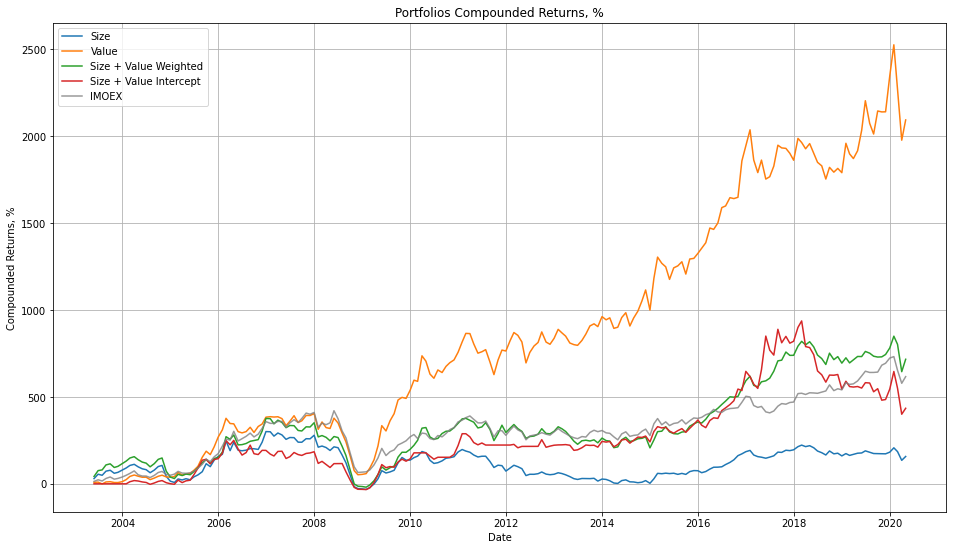

,Size,Value,Size + Value Weighted,Size + Value Intercept
"Total Return, %",157.32,2093.94,716.67,434.72
"CAGR, %",5.72,19.92,13.15,10.36
"Mean Return, %",12.32* (1.40),22.47*** (3.17),18.57** (2.21),16.08** (1.85)
"Volatility, %",36.32,29.21,34.66,35.75
"Win Rate, %",52.45,58.33,60.29,48.04
"Mean Turnover, %",235.33,223.41,219.51,323.90
"Maximum Drawdown, %",-83.08,-69.79,-83.06,-80.88
"Value at Risk, %",-52.80,-33.39,-47.20,-44.44
"Expected Tail Loss, %",-77.82,-53.15,-75.59,-68.02
"Expected Tail Reward, %",91.36,77.59,88.43,98.09


In [9]:
size_value_intercept_portfolio = builder(
    universe,
    longs=q02(size) & q02(value),
    name="Size + Value Intercept"
)

summary([size_portfolio, value_portfolio, size_value_weighted_portfolio, size_value_intercept_portfolio])

# Double Sort Multifactor

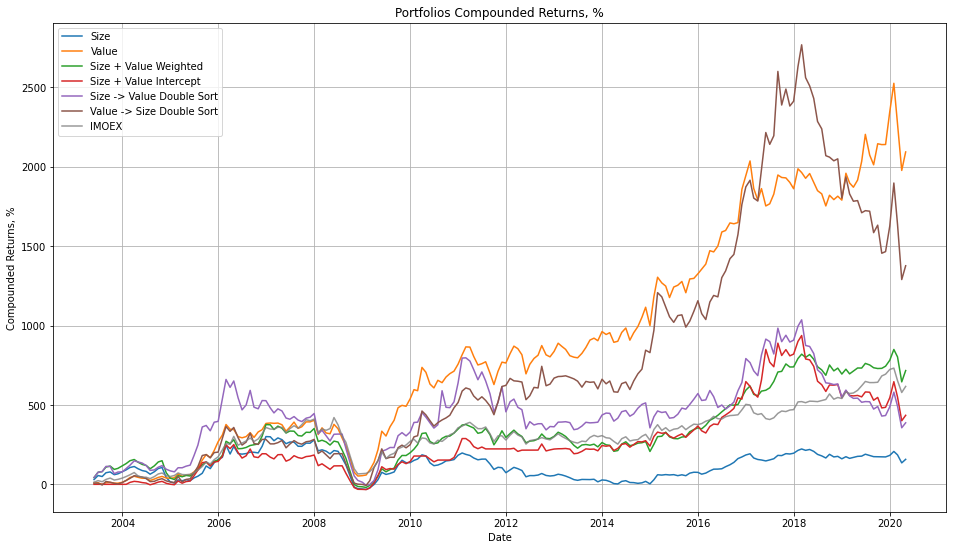

,Size,Value,Size + Value Weighted,Size + Value Intercept,Size -> Value Double Sort,Value -> Size Double Sort
"Total Return, %",157.32,2093.94,716.67,434.72,387.48,1376.90
"CAGR, %",5.72,19.92,13.15,10.36,9.77,17.16
"Mean Return, %",12.32* (1.40),22.47*** (3.17),18.57** (2.21),16.08** (1.85),18.29** (1.72),23.49*** (2.41)
"Volatility, %",36.32,29.21,34.66,35.75,43.72,40.24
"Win Rate, %",52.45,58.33,60.29,48.04,54.90,54.41
"Mean Turnover, %",235.33,223.41,219.51,323.90,398.05,392.20
"Maximum Drawdown, %",-83.08,-69.79,-83.06,-80.88,-87.69,-79.82
"Value at Risk, %",-52.80,-33.39,-47.20,-44.44,-60.50,-48.90
"Expected Tail Loss, %",-77.82,-53.15,-75.59,-68.02,-81.10,-72.17
"Expected Tail Reward, %",91.36,77.59,88.43,98.09,121.46,113.05


In [10]:
size_universe = pqr.Universe(prices)
size_universe.filter(q02(size))

sort_factorizer_size = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Mean(3),
    pqr.Hold(3),
    pqr.Filter(size_universe)
)

value_presorted = sort_factorizer_size(pe, better="less")

size_value_double_sort_portfolio = builder(
    universe,
    longs=q02(value_presorted),
    name="Size -> Value Double Sort"
)


value_universe = pqr.Universe(prices)
value_universe.filter(q02(value))

sort_factorizer_value = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Mean(3),
    pqr.Hold(3),
    pqr.Filter(value_universe)
)

size_presorted = sort_factorizer_value(mcap, better="less")


value_size_double_sort_portfolio = builder(
    universe,
    longs=q02(size_presorted),
    name="Value -> Size Double Sort"
)


summary(
    [
        size_portfolio, value_portfolio, 
         size_value_weighted_portfolio, 
         size_value_intercept_portfolio,
         size_value_double_sort_portfolio,
         value_size_double_sort_portfolio
    ]
)